# Doc2Vec을 기반한 뉴스 연관 추천

## 1. 뉴스 데이터 로드

In [5]:
from doc2vec.util.Logger import Logger
from doc2vec.util.conf_parser import Parser
from doc2vec.elastic.analyzer.nori_analyzer import NoriAnalyzer
from doc2vec.preprocessing.preprocessing import *
from doc2vec.util.common import load_pickle, save_pickle
from doc2vec.preprocessing.preprocessing import generate_tagged_document_by_pandas, load_pdf, is_contain_str
import pandas as pd 
from doc2vec.model.doc2vec import build_model
from doc2vec.util.common import set_pandas_format, set_matplotlib_sns_font

In [6]:
set_pandas_format()
set_matplotlib_sns_font()
logger = Logger(file_name=__name__).logger
p = Parser()

nori = NoriAnalyzer(**p.elastic_conf)

2022-03-21 23:30:41,487 [INFO] - SchemaGenerator.py:__init__ - line:33 - loading index_patterns from NoriAnalyzer
2022-03-21 23:30:41,491 [INFO] - SchemaGenerator.py:_load_templates - line:130 - load index_pattern file path = /Users/jmac/project/jtbc_news_data/analyzer/doc2vec/schema_json/NoriAnalyzer/nori-analyzer-template.json
2022-03-21 23:30:41,494 [INFO] - SchemaGenerator.py:_load_templates - line:134 - load index_pattern : nori-analyzer-template 
2022-03-21 23:30:41,495 [INFO] - SchemaGenerator.py:_load_templates - line:143 - 	update {'number_of_shards': 1, 'number_of_replicas': 2, 'analysis': {'analyzer': {'my_analyzer': {'type': 'custom', 'tokenizer': 'my-nori-tokenizer', 'filter': ['uppercase', 'synonym_filtering', 'stop_filtering', 'remove_duplicates', 'part_of_speech_stop_sp']}}, 'tokenizer': {'my-nori-tokenizer': {'type': 'nori_tokenizer', 'decompound_mode': 'none', 'discard_punctuation': 'true', 'user_dictionary_rules': ['LG엔솔', '방역패스', '쓰나미', '초강력', '대형마트', '형평성', '외무상', 

In [3]:
ori_df = load_pdf("news.csv", sep="^")

print(ori_df.shape)
ori_df.drop_duplicates(['news_id'], keep='last', inplace=True)

# 제거할 거 (news_nm기준으로 제거, 13,405 -> 12,553로 의미 없는 기사 제거 )
# - 클로징, BGM, 썰전 라이브 다시보기(-> 이건 text 내용이 없음)
# 사용자 history 기반 news 수 :
#          news_id  ...                                       news_content
# 65139  NB12045093  ...  <div id='div_NV10478125' ...
# 65140  NB12045094  ...  <div id='div_NV10478127' ...
ori_df['is_in_str'] = ori_df['news_nm'].apply(is_contain_str)
df = ori_df[~ori_df['is_in_str']==True].copy()
df.reset_index(drop=True, inplace=True)
print(df.shape)

df.tail()



file_path : /Users/jmac/project/jtbc_news_data/analyzer/data/rec/news.csv
file_name : news.csv
DATA INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13405 entries, 0 to 13404
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype                                
---  ------        --------------  -----                                
 0   news_id       13405 non-null  object                               
 1   news_nm       13405 non-null  object                               
 2   section       13405 non-null  object                               
 3   service_date  13405 non-null  datetime64[ns, pytz.FixedOffset(540)]
 4   news_content  13405 non-null  object                               
dtypes: datetime64[ns, pytz.FixedOffset(540)](1), object(4)
memory usage: 523.8+ KB

----------------------------------------------------------------------------------------------------
DATA IS_NULL
+--------------+-----+
|              |   0 |
|--------------+-----|
| news_i

,news_id,news_nm,section,service_date,news_content,is_in_str
12548,NB12048876,[백브리핑] 여야 의원들에게 시급한 '현안'은…나라 걱정? 당 걱정!,정치,2022-02-28 20:43:00+09:00,<div id='div_NV10482274' class='jtbc_vod'></di...,False
12549,NB12048878,"'처방전 발급' 의사 ""말하면 수사 저촉""…약국 측 ""직접 안 와""",정치,2022-02-28 20:10:00+09:00,<div id='div_NV10482250' class='jtbc_vod'></di...,False
12550,NB12048879,[이슈체크] '인수위 공동운영'까지 합의했다지만…양측 주장은,정치,2022-02-28 20:31:00+09:00,<div id='div_NV10482254' class='jtbc_vod'></di...,False
12551,NB12048881,"러시아-우크라이나, 벨라루스서 협상 시작",국제,2022-02-28 19:36:00+09:00,"<div id=""txtTag550_newsjam_photo202202284d9e03...",False
12552,NB12048884,"러시아 국방부 ""핵 전력 강화태세 돌입""",정치,2022-02-28 23:04:00+09:00,"로이터통신은 ""러시아 인테르팍스 통신이 '러시아 국방부가 푸틴 대통령의 지시에...",False


## 2. elastic 기반 형태소 분석 수행 (with. nori analyzer)

위에서 로드한 news.csv 파일에서 news_nm과 news_content를 기준으로 사전에 구축 및 nori 플러그인이 설치된 elastic에 analyzer를 수행하여
형태소 분석된 결과를 parsing_data_df(pandas) 형태로 저장
- 참고로 elastic analyze에서는 list 형태로 데이터 분석에 제한이 있어서 우선 step=10으로 10개의 documents 단위로 형태소 분석을 수행함

In [ ]:
save_flag = True

step = 10

analyzed_df = pd.DataFrame(columns=['news_id', 'tagged_doc'])

news_contents_parsing = {}
nori.update_index_setting()
for idx in range(0, df.shape[0], step):
    if idx + step > df.shape[0]:
        parsing_df = df.iloc[idx: df.shape[0]][['news_id', 'news_content', 'news_nm']]
    else:
        parsing_df = df.iloc[idx: idx + step][['news_id', 'news_content', 'news_nm']]

    tmp_parsing = nori.get_parsing_news_contents_from_csv(parsing_df)
    news_contents_parsing.update(tmp_parsing)
    result_df = pd.DataFrame({'news_id': list(tmp_parsing.keys()), 'tagged_doc': list(tmp_parsing.values())})
    analyzed_df = pd.concat([analyzed_df, result_df], axis=0)

if save_flag:
    save_pickle(os.path.join(rootpath.detect(), *["data", "rec", "parsing_data.pickle"]), news_contents_parsing)
    save_pickle(os.path.join(rootpath.detect(), *["data", "rec", "parsing_data_df.pickle"]),
                analyzed_df)

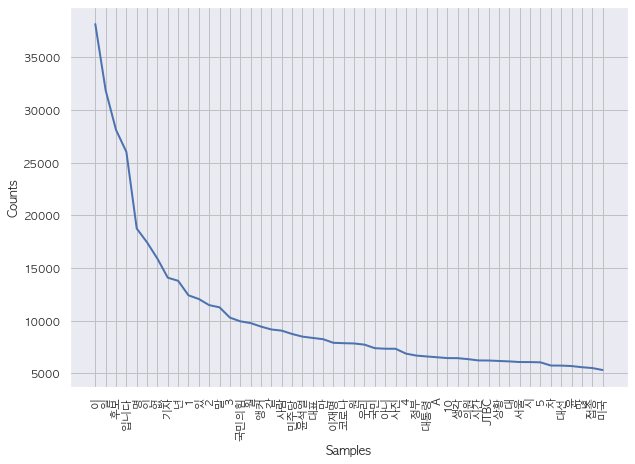

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [8]:

from nltk.probability import FreqDist
parsing_df = load_pickle(os.path.join(rootpath.detect(), *["data", "rec", "parsing_data_df.pickle"]))

word_split = []
for i in range(len(parsing_df)):
    for j in parsing_df.iloc[i]['tagged_doc']:
        word_split.append(j)

# 사전 업데이트가 조금 필요한 듯 ㅠㅠ
FreqDist(word_split).plot(50)

## 3. doc2vec 모델 생성을 위한 데이터 변환 및 분할

elastic기반으로 형태소 분석된 데이터를 TaggedDocument로 변환하고
검증을 위해 훈련데이터와 검증 데이터를 나뉨

TaggedDocument는 words와 tags로 정의 됨
- TaggedDocument(['홍남기', '부총리', '기획', '재정부', '장관', ..., '통보'], ['2022030610442141299'])

In [12]:
from sklearn.model_selection import train_test_split

parsing_data_df_path = os.path.join(rootpath.detect(), *["data", "rec", "parsing_data_df.pickle"])
parsing_data_df = load_pickle(parsing_data_df_path)

x_train, x_test, y_train, y_test = train_test_split(parsing_data_df[['tagged_doc']],
                                                    parsing_data_df['news_id'],
                                                    test_size=0.3,
                                                    shuffle=True,
                                                    random_state=42)
x_train = x_train.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
print("x_train.shape= ", x_train.shape, ", y_train.shape= ", y_train.shape)
print("x_test.shape= ", x_test.shape, ", y_test.shape= ", y_test.shape)

train_tagged_doc = generate_tagged_document_by_pandas(x_train, y_train)
test_tagged_doc = generate_tagged_document_by_pandas(x_test, y_test)

save_pickle(os.path.join(rootpath.detect(), *["data", "rec", "train_tagged_doc.pickle"]), train_tagged_doc)
save_pickle(os.path.join(rootpath.detect(), *["data", "rec", "test_tagged_doc.pickle"]), test_tagged_doc)

x_train.shape=  (8787, 1) , y_train.shape=  (8787,)
x_test.shape=  (3766, 1) , y_test.shape=  (3766,)


## 4. 모델 생성 및 저장

doc2vec 모델을 위해서 gensim을 사용하였으며, 모델에 대한 정의는 doc2vec/model/doc2vec.py에 정의 되어 있음

일반적으로 dm=1 즉, PV-DM 학습 방법이 성능이 더 좋다고 하여 해당 방법을 채택

또한 vector_size가 크면 좋지만, 그에 따른 학습 속도가 길어지기 때문에 vector_size와 windows 사이즈에 대한 성능 측정을 참고하여 vector_size=1000, window=3을 선택


참고: 내부에서 정의된 모델 정보 (병렬처리 하게끔 설정함)


    model = gensim.models.doc2vec.Doc2Vec(vector_size=1000, min_count=2, epochs=100,
                                            alpha=0.025, min_alpha=0.00025, workers=cores,
                                            window=3, dm=1, seed=9999)
                                


In [ ]:
tagged_doc = load_pickle(os.path.join(rootpath.detect(), *["data", "rec", "train_tagged_doc.pickle"]))

# 모델 불러오기
d2v_model = build_model()

# 사전 구축
d2v_model.build_vocab(tagged_doc)

# 모델 훈련
d2v_model.train(tagged_doc, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)

d2v_model.save(os.path.join(rootpath.detect(), *['model', 'model.doc2vec']))

모델 테스트는 아래와 같이 가볍게 할 수 있음:

- 아래는 검증 데이터를 기반으로 훈련된 모델에서 문서에 대한 vector가 주어졌을때 vector를 뽑아줌

In [14]:
test_tagged_doc = load_pickle(os.path.join(rootpath.detect(), *["data", "rec", "test_tagged_doc.pickle"]))

d2v_model = gensim.models.doc2vec.Doc2Vec.load(os.path.join(rootpath.detect(), *['model', 'model.doc2vec']))

print(test_tagged_doc[0])
vector = d2v_model.infer_vector(test_tagged_doc[0].words)
print("vector size = ", len(vector))
print("Top 10 values in Doc2Vec inferred vecotr: ")
print(vector[:10])

2022-03-16 16:31:38,902 [INFO] - utils.py:load - line:481 - loading Doc2Vec object from /Users/jmac/project/jtbc_news_data/analyzer/model/model.doc2vec
2022-03-16 16:31:38,972 [INFO] - utils.py:_load_specials - line:515 - loading dv recursively from /Users/jmac/project/jtbc_news_data/analyzer/model/model.doc2vec.dv.* with mmap=None
2022-03-16 16:31:38,974 [INFO] - utils.py:_load_specials - line:515 - loading wv recursively from /Users/jmac/project/jtbc_news_data/analyzer/model/model.doc2vec.wv.* with mmap=None
2022-03-16 16:31:38,975 [INFO] - utils.py:_load_specials - line:520 - loading vectors from /Users/jmac/project/jtbc_news_data/analyzer/model/model.doc2vec.wv.vectors.npy with mmap=None
2022-03-16 16:31:39,106 [INFO] - utils.py:_load_specials - line:520 - loading syn1neg from /Users/jmac/project/jtbc_news_data/analyzer/model/model.doc2vec.syn1neg.npy with mmap=None
2022-03-16 16:31:39,240 [INFO] - utils.py:_load_specials - line:553 - setting ignored attribute cum_table to None
202

TaggedDocument(['추미애', '신천지', '압수수색', '영장', '윤석열', '지시', '반려', '추미애', '법무부', '장관', '사진', '국회', '사진', '기자단', '추미애', '법무부', '장관', '당시', '검찰', '총장', '이', '윤석열', '국민의힘', '대선', '후보', '신천지', '압수수색', '영장', '차례', '반려', '주장', '추', '장관', '오늘', '21', '일', 'MBC', '라디오', '김종배', '시선', '집중', '출연', '윤', '후보', '총선', '인데', '방역', '실패', '집권당', '선거', '심판', '검찰', '선거', '개입', '반려', '지시', '이', '진행자', '당시', '대검찰청', '사람', '얘기', '대검', '사람', '아니', '윤석열', '총장', '큰일', '입니다', '구두', '답', '추', '장관', '당시', '윤', '후보', '영장', '반려', '지시', '배경', '건진법사', '관여', '이', '그', '그건', '겉', '이야기', '였', '윤', '후보', '당시', '대통령', '계획', '있', '윤석열', '누구', '인지', '국민', '각인', '이만희', '총회장', '처리', '수사', '건진법사', '말', '이', '건진법사', '총회장', '하나', '영매', '인데', '대통령', '걸림돌', '손', '피', '부드럽', '조언', '주장', '이', '진행자', '건진법사', '조언', '있', '추가', '파악', '내용', '추', '장관', '없', '실제', '차례', '영장', '기각', '있', '정치', '발언', '법사', '정치', '동기', '앞뒤', '맥락', '같', '답'], ['NB12043728'])
vector size =  1000
Top 10 values in Doc2Vec inferred vecotr: 
[-1.218271   -1.2903349  -0.

In [17]:
# 모델에 훈련된 tags를 확인 하는 방법
d2v_model = gensim.models.doc2vec.Doc2Vec.load(os.path.join(rootpath.detect(), *['model', 'model.doc2vec']))
print(d2v_model.dv.index_to_key[:10])

2022-03-16 16:32:10,526 [INFO] - utils.py:load - line:481 - loading Doc2Vec object from /Users/jmac/project/jtbc_news_data/analyzer/model/model.doc2vec
2022-03-16 16:32:10,553 [INFO] - utils.py:_load_specials - line:515 - loading dv recursively from /Users/jmac/project/jtbc_news_data/analyzer/model/model.doc2vec.dv.* with mmap=None
2022-03-16 16:32:10,554 [INFO] - utils.py:_load_specials - line:515 - loading wv recursively from /Users/jmac/project/jtbc_news_data/analyzer/model/model.doc2vec.wv.* with mmap=None
2022-03-16 16:32:10,555 [INFO] - utils.py:_load_specials - line:520 - loading vectors from /Users/jmac/project/jtbc_news_data/analyzer/model/model.doc2vec.wv.vectors.npy with mmap=None
2022-03-16 16:32:10,585 [INFO] - utils.py:_load_specials - line:520 - loading syn1neg from /Users/jmac/project/jtbc_news_data/analyzer/model/model.doc2vec.syn1neg.npy with mmap=None
2022-03-16 16:32:10,627 [INFO] - utils.py:_load_specials - line:553 - setting ignored attribute cum_table to None
202

['NB12031342', 'NB12027033', 'NB12020360', 'NB12042114', 'NB12034288', 'NB12043582', 'NB12038667', 'NB12043899', 'NB12034863', 'NB12047674']


## 5. 연관 문서 추천 (doc2vec)

훈련 데이터를 기반으로 특정 문서를 넣었을때, 해당 문서와 유사한 문서를 훈련된 모델로 찾음

참고: 자기 자신 제외는 아직 로직 상 집어 넣지 않았음.

(그래도 결과적으로 유사한 뉴스가 나옴)


In [18]:
def _check_sim_news(data, news_df, d2v_model):

    for a_data in data:
        selected_news_id = a_data.tags[0]
        selected_news_df = news_df[news_df['news_id'] == selected_news_id][['news_id', 'news_nm', 'news_content']]
        print("\n=============================================================================================================")
        print(f"[{selected_news_id}] {selected_news_df.news_nm.values[0]}")
        inferred = d2v_model.infer_vector(a_data.words)
        sims = d2v_model.dv.most_similar(inferred, topn=5)

        for sim in sims:
            news_id = sim[0]
            sim_value = sim[1]
            tmp_sim_news_df = news_df[news_df['news_id'] == news_id][
                ['news_id', 'news_nm', 'news_content']]
            if not tmp_sim_news_df.empty:
                print(f" 연관추천 [{news_id} ({sim_value})] {tmp_sim_news_df.news_nm.values[0]}")
        print("\n")

In [25]:
# news_df = load_pdf('news.csv', sep="^")

d2v_model = gensim.models.doc2vec.Doc2Vec.load(os.path.join(rootpath.detect(), *['model', 'model.doc2vec']))
# data = load_pickle(os.path.join(rootpath.detect(), *["data", "rec", "train_tagged_doc.pickle"]))
data = load_pickle(os.path.join(rootpath.detect(), *["data", "rec", "test_tagged_doc.pickle"]))

_check_sim_news(data[:7], df, d2v_model)

2022-03-17 10:53:54,390 [INFO] - utils.py:load - line:481 - loading Doc2Vec object from /Users/jmac/project/jtbc_news_data/analyzer/model/model.doc2vec
2022-03-17 10:53:54,588 [INFO] - utils.py:_load_specials - line:515 - loading dv recursively from /Users/jmac/project/jtbc_news_data/analyzer/model/model.doc2vec.dv.* with mmap=None
2022-03-17 10:53:54,589 [INFO] - utils.py:_load_specials - line:515 - loading wv recursively from /Users/jmac/project/jtbc_news_data/analyzer/model/model.doc2vec.wv.* with mmap=None
2022-03-17 10:53:54,590 [INFO] - utils.py:_load_specials - line:520 - loading vectors from /Users/jmac/project/jtbc_news_data/analyzer/model/model.doc2vec.wv.vectors.npy with mmap=None
2022-03-17 10:53:54,750 [INFO] - utils.py:_load_specials - line:520 - loading syn1neg from /Users/jmac/project/jtbc_news_data/analyzer/model/model.doc2vec.syn1neg.npy with mmap=None
2022-03-17 10:53:54,861 [INFO] - utils.py:_load_specials - line:553 - setting ignored attribute cum_table to None
202


[NB12031342] 힙합 가수 트래비스 스콧 공연 도중 관객 8명 압사
 연관추천 [NB12031342 (0.924715518951416)] 힙합 가수 트래비스 스콧 공연 도중 관객 8명 압사
 연관추천 [NB12031316 (0.5869700312614441)] 미 콘서트장서 압사 사고…8명 숨지고 300여 명 다쳐
 연관추천 [NB11997213 (0.41196778416633606)] 전남 장흥 호계터널서 SUV 차량 1톤 트럭 추돌…1명 부상
 연관추천 [NB12019314 (0.39683055877685547)] 모녀 탄 자동차, 경계석 충돌 후 추락…나무에 걸려 구조
 연관추천 [NB12041958 (0.39391034841537476)] '평택 화재' 순직 소방관 합동영결식…문 대통령도 참석



[NB12027033] NC, 키움 조상우 무너뜨리고 '가을야구' 실낱 희망
 연관추천 [NB12027033 (0.9245533347129822)] NC, 키움 조상우 무너뜨리고 '가을야구' 실낱 희망
 연관추천 [NB12021205 (0.6930510401725769)] 삼성, SSG에 9회말 4점 추가 '대역전승'…2위 도약
 연관추천 [NB12014624 (0.6308066844940186)] 선두 kt 6연승 행진…강백호 시즌 첫 100안타
 연관추천 [NB12001751 (0.6208816170692444)] 오승환 KBO 최초 300세이브…키움, SSG에 짜릿한 역전승
 연관추천 [NB12013646 (0.6161426901817322)] '5회 6점 집중력' SSG, 열세 뒤집고 LG 6연승 저지



[NB12020360] 거리 곳곳 '총 든' 탈레반…카불 공항 일단 운영 재개
 연관추천 [NB12020360 (0.9367651343345642)] 거리 곳곳 '총 든' 탈레반…카불 공항 일단 운영 재개
 연관추천 [NB12020257 (0.5032171010971069)] 대탈출 행렬 카불공항 '혼돈'…민항기·군용기 운항 중단
 연관추